<a href="https://colab.research.google.com/github/gabrielbelo2007/CardiopatiaModel/blob/XGBoost_%26_SVM/SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Configurações

In [41]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.decomposition import PCA

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_auc_score,
    RocCurveDisplay,
    fbeta_score,
    make_scorer
)

import matplotlib.pyplot as plt


In [23]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Carregar Dataset

In [24]:
df = pd.read_csv("/content/drive/MyDrive/Ps Ligia Time 16/risco_cardiovascular_features.csv")
df.head()

,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Heart Rate,Daily Steps,Sleep Disorder,BP_Category,HighRisk,Sleep_Efficiency,Cardiac_Stress_Index
0,Male,27,Software Engineer,6.1,6,42,6,Overweight,77,4200,No Disorder,Normal,0,36.6,462
1,Male,28,Doctor,6.2,6,60,8,Normal Weight,75,10000,No Disorder,Normal,0,37.2,600
2,Male,28,Doctor,6.2,6,60,8,Normal Weight,75,10000,No Disorder,Normal,0,37.2,600
3,Male,28,Sales Representative,5.9,4,30,8,Obese,85,3000,Sleep Apnea,Hypertension_Stage1,1,23.6,680
4,Male,28,Sales Representative,5.9,4,30,8,Obese,85,3000,Sleep Apnea,Hypertension_Stage1,1,23.6,680


In [25]:
df.info()
df["HighRisk"].value_counts(normalize=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 374 entries, 0 to 373
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Gender                   374 non-null    object 
 1   Age                      374 non-null    int64  
 2   Occupation               374 non-null    object 
 3   Sleep Duration           374 non-null    float64
 4   Quality of Sleep         374 non-null    int64  
 5   Physical Activity Level  374 non-null    int64  
 6   Stress Level             374 non-null    int64  
 7   BMI Category             374 non-null    object 
 8   Heart Rate               374 non-null    int64  
 9   Daily Steps              374 non-null    int64  
 10  Sleep Disorder           374 non-null    object 
 11  BP_Category              374 non-null    object 
 12  HighRisk                 374 non-null    int64  
 13  Sleep_Efficiency         374 non-null    float64
 14  Cardiac_Stress_Index     3

,proportion
HighRisk,
0,0.73262
1,0.26738


##Separação de Features e Target

In [26]:
X = df.drop(columns=["BP_Category", "HighRisk"])
y = df["HighRisk"]

## Divisão de Teste e Treino

In [27]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

## Encoding e Transformações

In [34]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

num_features = [
    "Age", "Sleep Duration", "Quality of Sleep",
    "Physical Activity Level", "Stress Level",
    "Heart Rate", "Daily Steps",
    "Sleep_Efficiency", "Cardiac_Stress_Index"
]

ord_features = ["BMI Category"]
bmi_order = ["Underweight", "Normal Weight", "Overweight", "Obese"]
nom_features = ["Gender", "Occupation", "Sleep Disorder"]


preprocessor = ColumnTransformer([
    ("num", StandardScaler(), num_features),
    ("ord", OrdinalEncoder(categories=[bmi_order]), ord_features),
    ("nom", OneHotEncoder(handle_unknown="ignore"), nom_features)
])


## Pipeline

In [35]:
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ("pca", PCA()),
    ('svm', SVC(kernel='rbf', class_weight='balanced', probability=True, random_state=42))
])


In [36]:
# F2-Score (Atribui peso dobrado ao Recall em relação a Precisão)

f2_scorer = make_scorer(fbeta_score, beta=2, average='binary')

## Grid Search

In [37]:
param_grid = [
    # --- Linear kernel ---
    {
        "pca": ["passthrough", PCA(n_components=0.95)],
        "svm__kernel": ["linear"],
        "svm__C": [0.1, 1, 10, 100],
    },

    # --- RBF kernel ---
    {
        "pca": ["passthrough", PCA(n_components=0.95)],
        "svm__kernel": ["rbf"],
        "svm__C": [0.1, 1, 10, 100],
        "svm__gamma": ["scale", "auto", 0.01, 0.1, 1],
    }
]


In [38]:
from sklearn.model_selection import GridSearchCV

grid = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    scoring=f2_scorer,
    cv=5,
    n_jobs=-1
)

grid.fit(X_train, y_train)
print("Melhor config:", grid.best_params_)
print("Melhor score (F2):", grid.best_score_)


Melhor config: {'pca': 'passthrough', 'svm__C': 10, 'svm__kernel': 'linear'}
Melhor score (F2): 0.9975308641975309


## Avaliação do Modelo

              precision    recall  f1-score   support

           0     1.0000    0.9818    0.9908        55
           1     0.9524    1.0000    0.9756        20

    accuracy                         0.9867        75
   macro avg     0.9762    0.9909    0.9832        75
weighted avg     0.9873    0.9867    0.9868        75

F2 (test): 0.9900990099009901


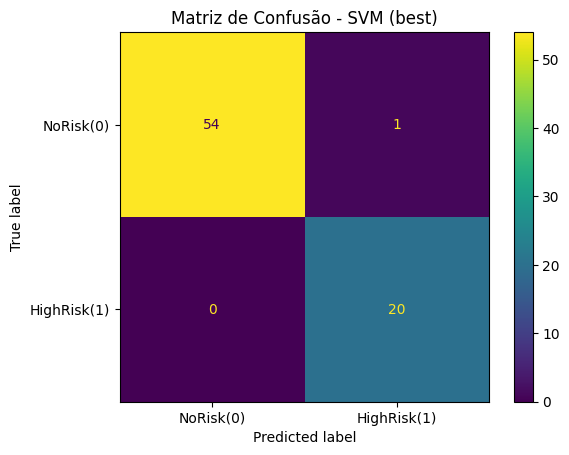

In [42]:
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)

print(classification_report(y_test, y_pred, digits=4))
print("F2 (test):", fbeta_score(y_test, y_pred, beta=2, average="binary"))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=["NoRisk(0)", "HighRisk(1)"])
disp.plot()
plt.title("Matriz de Confusão - SVM (best)")
plt.show()

O modelo apresentou excelente desempenho na classificação binária de risco cardiovascular, alcançando recall de 100% para a classe de alto risco e F2-score próximo a 0.99 no conjunto de teste. O modelo não apresentou falsos negativos, característica fundamental em aplicações médicas, indicando forte potencial para uso em triagem.

In [43]:
print("Distribuição y_train:", pd.Series(y_train).value_counts(normalize=True))
print("Distribuição y_test :", pd.Series(y_test).value_counts(normalize=True))


Distribuição y_train: HighRisk
0    0.732441
1    0.267559
Name: proportion, dtype: float64
Distribuição y_test : HighRisk
0    0.733333
1    0.266667
Name: proportion, dtype: float64


ROC-AUC (test): 0.9999999999999999


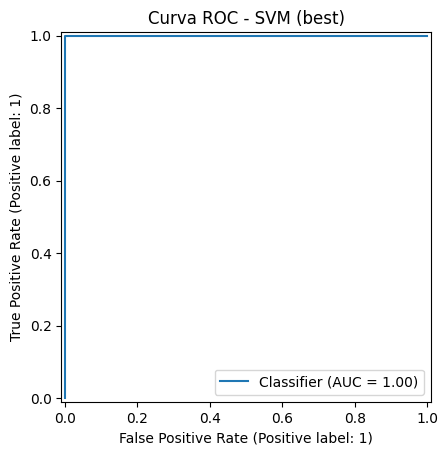

In [44]:
from sklearn.metrics import roc_auc_score, RocCurveDisplay
import matplotlib.pyplot as plt

best_model = grid.best_estimator_
y_proba = best_model.predict_proba(X_test)[:, 1]

auc = roc_auc_score(y_test, y_proba)
print("ROC-AUC (test):", auc)

RocCurveDisplay.from_predictions(y_test, y_proba)
plt.title("Curva ROC - SVM (best)")
plt.show()


O SVM apresentou desempenho quase perfeito no conjunto de teste, indicando alta capacidade de separação entre as classes. Entretanto, devido ao caráter sintético do dataset e à forte correlação entre as variáveis explicativas e o target, esse resultado não deve ser interpretado como evidência de generalização clínica.

In [45]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report, fbeta_score

dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_train, y_train)
y_dummy = dummy.predict(X_test)

print(classification_report(y_test, y_dummy, digits=4))
print("F2 dummy:", fbeta_score(y_test, y_dummy, beta=2, average="binary"))


              precision    recall  f1-score   support

           0     0.7333    1.0000    0.8462        55
           1     0.0000    0.0000    0.0000        20

    accuracy                         0.7333        75
   macro avg     0.3667    0.5000    0.4231        75
weighted avg     0.5378    0.7333    0.6205        75

F2 dummy: 0.0


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Como baseline, foi avaliado um DummyClassifier que sempre prediz a classe majoritária. O modelo obteve F2-score igual a 0, não sendo capaz de identificar nenhum caso de alto risco. Em contraste, o SVM apresentou recall de 100% para a classe de interesse, evidenciando aprendizado efetivo além de um baseline trivial.